In [98]:
import numpy as np 
import healpy as hp
import matplotlib.pyplot as plt
from glob import glob
import mylib
from tqdm import tqdm
from importlib import reload
import pymaster as nmt
import mylib

In [99]:
nside = 256
lmax = 3*nside - 1
npix = 12 * nside**2
nmc = 20

ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
c2d = ell_input*(ell_input+1)/2/np.pi
# input_cls = np.array([TT, EE, np.zeros_like(EE), TE]) #no BB
input_cls = np.array([TT, EE, BB, TE]) 
input_cls /= c2d 
for c in input_cls: c[0] = 0 
input_cls = input_cls[:,:lmax+1]

/tmp/ipykernel_45714/3268449346.py:10: RuntimeWarning: invalid value encountered in divide
  input_cls /= c2d


In [100]:
noise = np.zeros((nmc, 3, npix))
signal_BBonly = np.zeros((nmc,3,npix))
full = np.zeros((nmc, 3, npix))

hits = hp.read_map('v3_hits.fits')
for mc in tqdm(range(nmc)):
    noise[mc] = hp.read_map(f'noise/out/{mc+20}/filterbin_filtered_map.fits', field=None)
    signal_BBonly[mc] = hp.read_map(f'signal_lcdm_BBonly/out/{mc+20}/filterbin_filtered_map.fits', field=None)
    full[mc] = hp.read_map(f'full_lcdm/out/{mc}/filterbin_filtered_map.fits', field=None)

100%|███████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.12s/it]


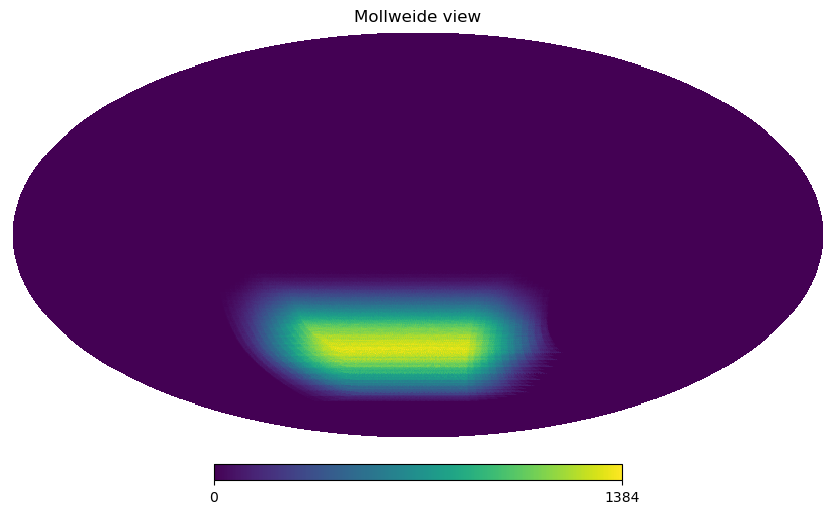

In [108]:
hp.mollview(hits)

In [106]:
mask = np.zeros_like(hits)
mask[hits!=0] = 1

15.064366658528646


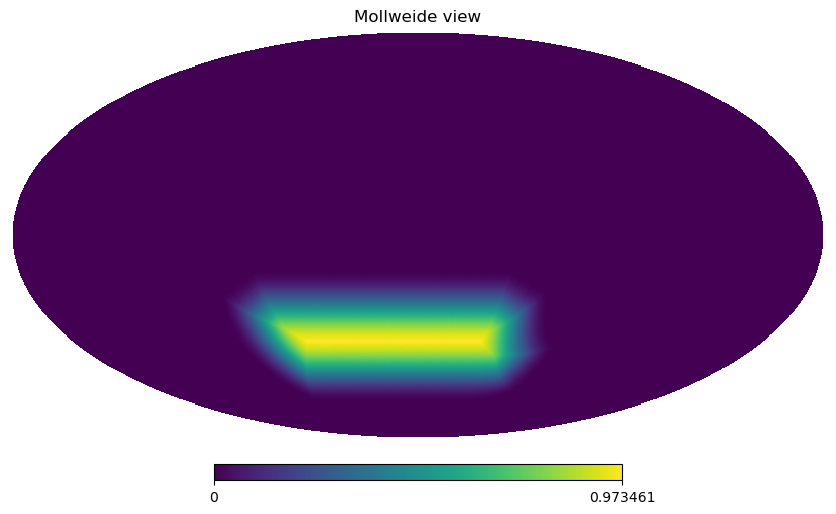

In [112]:
mask_apo = nmt.mask_apodization(mask, 30, apotype='C2')
hp.mollview(mask_apo)
fsky = len(mask_apo[(mask_apo!=0)])/npix
w2 = np.sum(mask_apo**2)/np.sum(mask)
w4 = np.sum(mask_apo**4)/np.sum(mask)
print(fsky*100)

In [113]:
reload(mylib)
b = nmt.NmtBin.from_nside_linear(nside, 20)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi
mll,_ = mylib.get_mll(mask_apo, nside, b, pol=False)
bl = hp.gauss_beam(np.deg2rad(17/60), lmax) #sat 145ghz

In [114]:
reload(mylib)
pcl_bb_vec = np.empty((nmc, lmax+1))
nl_vec = np.empty((nmc, 6, lmax+1))

for i in tqdm(range(nmc)):
    pcl_bb_vec[i] = hp.anafast(mask_apo*signal_BBonly[i])[2]
    nl_vec[i] = hp.anafast(mask_apo*noise[i])
    
pcl_bb= np.mean(pcl_bb_vec, axis=0)
nl = np.mean(nl_vec, axis=0)
nl_pol = np.array([nl[1], nl[4], nl[4], nl[2]]) #EE, EB, BE, BB for namaster format

100%|███████████████████████████████████████████████████| 20/20 [00:43<00:00,  2.16s/it]


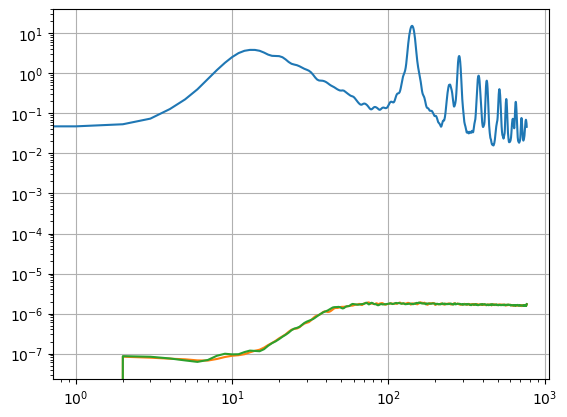

In [115]:
plt.plot(nl[0])
plt.plot(nl[1])
plt.plot(nl[2])
# plt.plot(nl[4])
plt.loglog()
plt.grid()

In [116]:
reload(mylib)
fl_bb = mylib.get_fl(input_cls[2], pcl_bb, bl, mll)

Text(0.5, 0, 'ell')

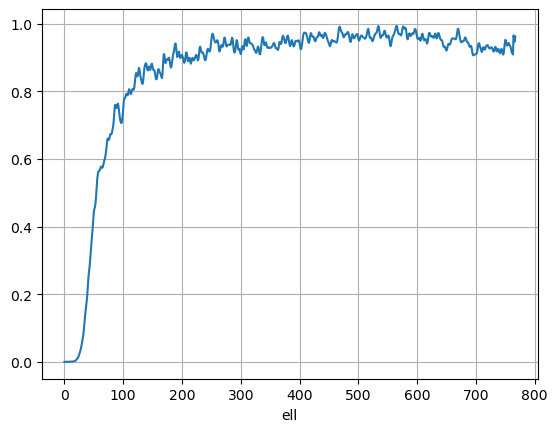

In [117]:
plt.plot(fl_bb)
# plt.xlim([10, 600])
# plt.ylim([0, 1])
plt.grid()
plt.xlabel('ell')
# plt.loglog()

In [118]:
cl = np.empty((nmc, 4, len(ells)))
for mc in tqdm(range(nmc)):
    f = nmt.NmtField(mask_apo, [full[mc][1], full[mc][2]], beam=bl*np.sqrt(fl_bb), purify_b=False)
    cl[mc] = nmt.compute_full_master(f, f, b, nl_pol)

cl_mean = c2db * np.mean(cl, axis=0)
cl_std = c2db * np.std(cl, axis=0)

100%|███████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.91s/it]


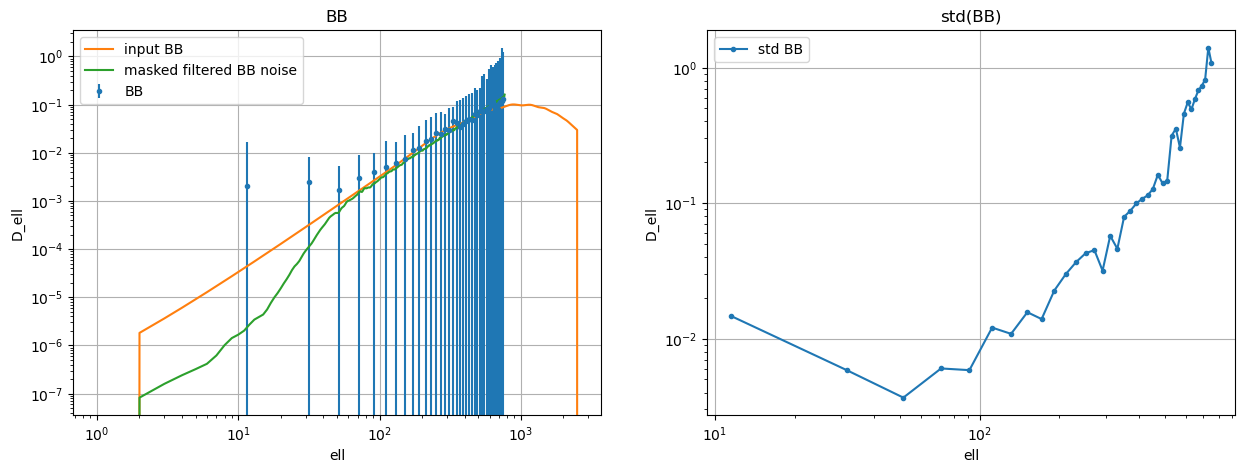

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].errorbar(ells, cl_mean[3], yerr=cl_std[3], fmt='.', label='BB')
axes[0].plot(ell_input, BB, label='input BB')
axes[0].plot(c2d[:lmax+1]*nl[2], label='masked filtered BB noise')
axes[0].set_title('BB')

axes[1].plot(ells, cl_std[3], marker='.',label='std BB')
# axes[1].plot(ells, c2db*(bpw@knox), label='knox')
axes[1].set_title('std(BB)')
# axes[1].set_ylim([1e-5,1e0])

for ax in axes.flatten():
    ax.legend()
    # ax.set_xlim([10,600])
    ax.loglog()
    ax.grid()
    ax.set_xlabel('ell')
    ax.set_ylabel('D_ell')